<a href="https://colab.research.google.com/github/harsh-s15/Speech-Emotion-DL/blob/main/spectral_CNN_dist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **2D CNN on spectral features**

---
refined dataset

In [ ]:
import numpy as np 
import matplotlib.pyplot as plt
import librosa
import librosa.display
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import tensorflow as tf
from keras import layers, models
import os, glob, pickle

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

In [ ]:
root = r'/content/drive/MyDrive/ser_updated/speech-emotion-recognition-ravdess-data/'

In [ ]:
emotions={
  '01':'neutral',
  '02':'calm',
  '03':'happy',
  '04':'sad',
  '05':'angry',
  '06':'fearful',
  '07':'disgust',
  '08':'surprised'
}

#Emotions to observe
observed_emotions=['calm', 'angry', 'fearful', 'disgust']

In [ ]:
def load_audio(audio_path, duration):
    audio, sr = librosa.load(audio_path, duration=duration)
    spec = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=128)
    spec_db = librosa.power_to_db(spec, ref=np.max)
    spec_db = spec_db.astype('float32')
    return spec_db

In [ ]:
def preprocess_data():
    x,y = [],[]
    for file in glob.glob(root + r'/Actor_*/*'):
        file_name=os.path.basename(file)
        emotion=emotions[file_name.split("-")[2]]
        if emotion not in observed_emotions:
            continue
        spec_db = load_audio(file, 3)
        if spec_db.shape != (128,130):
            continue
        x.append(spec_db)
        y.append(emotion)

    return np.array(x), np.array(y)

In [ ]:
X, y = preprocess_data()

In [ ]:
# Encode labels as integers
label_map = {label: i for i, label in enumerate(np.unique(y))}
y = np.array([label_map[label] for label in y])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
print(X_train.shape, y_train.shape)

(613, 128, 130) (613,)


In [ ]:
x_traincnn = np.expand_dims(X_train, axis=3)
x_testcnn = np.expand_dims(X_test, axis=3)

In [ ]:
x_traincnn.shape

(613, 128, 130, 1)

In [ ]:
input_shape = x_traincnn.shape[1:]
num_classes = 4
input_shape

(128, 130, 1)

In [ ]:
def create_model(input_shape, num_classes):
    model = models.Sequential()
    model.add(layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(num_classes, activation='softmax'))
    return model

In [ ]:
model = create_model(input_shape,num_classes)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 128, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 64, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 62, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 31, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 59520)             0         
                                                                 
 dense (Dense)               (None, 128)               7

In [ ]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
cnnhistory = model.fit(x_traincnn, y_train, batch_size=16, 
                       epochs=100, validation_data=(x_testcnn, y_test))

Epoch 1/100
39/39 [==============================] - 20s 472ms/step - loss: 26.9134 - accuracy: 0.3100 - val_loss: 1.0756 - val_accuracy: 0.5584
Epoch 2/100
39/39 [==============================] - 18s 458ms/step - loss: 1.0802 - accuracy: 0.5644 - val_loss: 0.8122 - val_accuracy: 0.6558
Epoch 3/100
39/39 [==============================] - 19s 470ms/step - loss: 0.6913 - accuracy: 0.7129 - val_loss: 0.7617 - val_accuracy: 0.6623
Epoch 4/100
39/39 [==============================] - 17s 443ms/step - loss: 0.7094 - accuracy: 0.7455 - val_loss: 0.7657 - val_accuracy: 0.7013
Epoch 5/100
39/39 [==============================] - 17s 449ms/step - loss: 0.4332 - accuracy: 0.8467 - val_loss: 0.7583 - val_accuracy: 0.6883
Epoch 6/100
39/39 [==============================] - 19s 486ms/step - loss: 0.2823 - accuracy: 0.8989 - val_loss: 0.7253 - val_accuracy: 0.7273
Epoch 7/100
39/39 [==============================] - 17s 444ms/step - loss: 0.1891 - accuracy: 0.9429 - val_loss: 0.8114 - val_accuracy

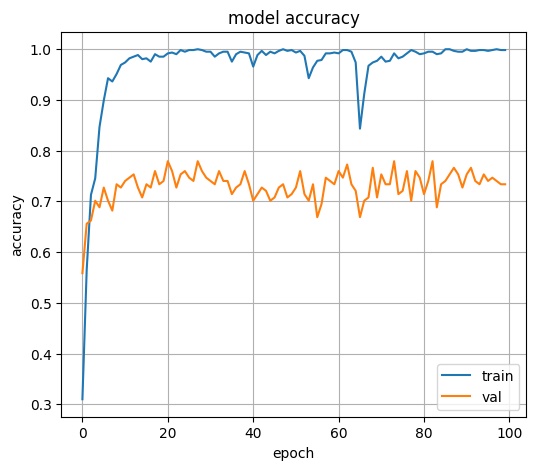

In [ ]:
plt.figure(figsize=(6,5))
plt.plot(cnnhistory.history['accuracy'])
plt.plot(cnnhistory.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.grid()
plt.show()

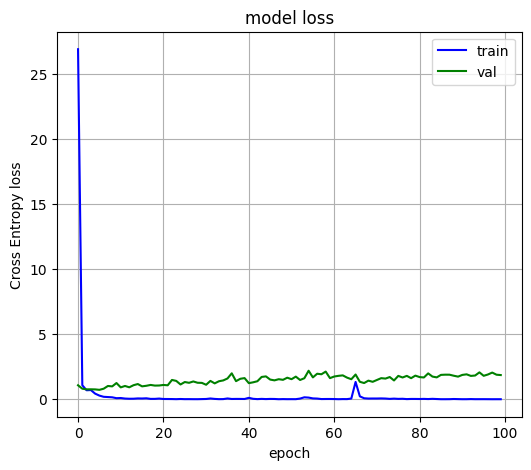

In [ ]:
plt.figure(figsize=(6,5))
plt.plot(cnnhistory.history['loss'],'blue')
plt.plot(cnnhistory.history['val_loss'],'green')
plt.title('model loss')
plt.ylabel('Cross Entropy loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.grid()
plt.show()

In [ ]:
test_loss, test_acc = model.evaluate(x_testcnn, y_test)
print('Test accuracy:', test_acc)

5/5 [==============================] - 1s 175ms/step - loss: 1.8606 - accuracy: 0.7338
Test accuracy: 0.7337662577629089


In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score as acc
def showConfMatrix(y_test,y_pred):
    ConfusionMatrixDisplay.from_predictions(y_test,y_pred,
                                                colorbar=False,
                                                cmap=plt.cm.Blues,
                                                xticks_rotation=45,
                                                display_labels=['angry','calm','fearful','disgust'])

5/5 [==============================] - 1s 177ms/step


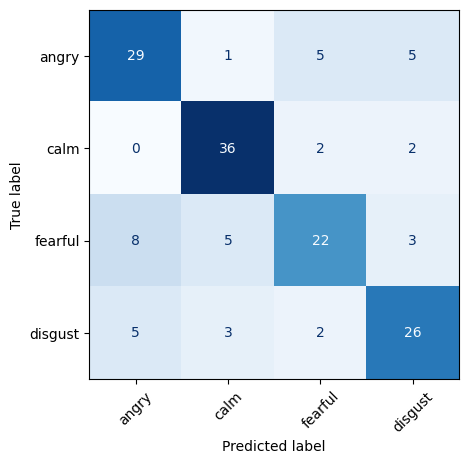

In [ ]:
y_pred = np.argmax(model.predict(x_testcnn),axis=1)
showConfMatrix(y_test,y_pred)